In [6]:
import pandas as pd
from pandas import read_csv
import xgboost as xgb

CONCATENATE CSV FILES

In [ ]:
data = []
for i in range(10):
    data.append(pd.read_csv(f'data/data_css_challenge_{i}.csv'))
data = pd.concat(data, ignore_index=True)
data = data.drop_duplicates()

/var/folders/zh/ymws8vv55_bcd4hfyt3fcpp40000gn/T/ipykernel_22380/2000877189.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data.append(pd.read_csv(f'data/data_css_challenge_{i}.csv'))
/var/folders/zh/ymws8vv55_bcd4hfyt3fcpp40000gn/T/ipykernel_22380/2000877189.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data.append(pd.read_csv(f'data/data_css_challenge_{i}.csv'))
/var/folders/zh/ymws8vv55_bcd4hfyt3fcpp40000gn/T/ipykernel_22380/2000877189.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data.append(pd.read_csv(f'data/data_css_challenge_{i}.csv'))
/var/folders/zh/ymws8vv55_bcd4hfyt3fcpp40000gn/T/ipykernel_22380/2000877189.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data.append(pd.read_csv(f'data/data_css_challenge_{i}.csv'))
/var/folders/zh/

TARIFF AND TARIFF_POSITION CONVERSION TO STR

In [19]:
data["tariff"] = data["tariff"].astype(str)
data["traiff_position"] = data["tariff_position"].astype(str)

In [ ]:
#data["first_two_digits_tariff_poisition"] = data["tariff_position"].str[:2]

CLEAN DATA

In [ ]:
mask = data["end_date"].isna()
data.loc[mask, "end_date"] = data.loc[mask, "start_date"]
mask = data["client_id"].isna()
data.loc[mask, "client_id"] = "Unknown client"
mask = data["client_type"].isna()
data.loc[mask, "client_type"] = "unknown"
mask = data["tariff_position"].isna()
data.loc[mask, "tariff_position"] = "missing"

In [54]:
data["start_date"] = pd.to_datetime(data["start_date"], errors="coerce")
data["end_date"]   = pd.to_datetime(data["end_date"], errors="coerce")
data["visit_day"] = data["start_date"].dt.floor("D")


# 3) Core features interpretabili per paziente
features = (
    data.groupby("patient_id").agg(
        n_visits=("patient_id", "size"),
        n_visit_days=("visit_day", "nunique"),
        n_providers=("healthcare_provider_id", pd.Series.nunique),
        n_provider_types=("healthcare_provider_type", pd.Series.nunique),
        n_client_ids=("client_id", pd.Series.nunique),
        n_client_groups=("client_main_group", pd.Series.nunique),
        n_tariff_positions=("tariff_position", pd.Series.nunique),
        qty_sum=("quantity", "sum"),
        first_visit=("start_date", "min"),
        last_visit=("start_date", "max"),
    )
    .reset_index()
)

# 4) Span temporale in giorni (facile da spiegare)
features["visit_span_days"] = (
    (features["last_visit"] - features["first_visit"]).dt.total_seconds() / (24*3600)
).astype(float)

# 5) Ordino colonne e salvo
col_order = [
    "patient_id",
    "n_visits", "n_visit_days", "visit_span_days",
    "n_providers", "n_provider_types", "n_client_ids", "n_client_groups", "n_tariff_positions",
    "qty_sum",
    "first_visit", "last_visit",
]
features = features[col_order]

features.to_csv("features_per_patient_core.csv", index=False)
print(features.head())
print(features.describe(include="all"))

/var/folders/zh/ymws8vv55_bcd4hfyt3fcpp40000gn/T/ipykernel_22380/2342382821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["start_date"] = pd.to_datetime(data["start_date"], errors="coerce")
/var/folders/zh/ymws8vv55_bcd4hfyt3fcpp40000gn/T/ipykernel_22380/2342382821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["end_date"]   = pd.to_datetime(data["end_date"], errors="coerce")
/var/folders/zh/ymws8vv55_bcd4hfyt3fcpp40000gn/T/ipykernel_22380/2342382821.py:3: SettingWithCopyWarning: 
A val

     patient_id  n_visits  n_visit_days  ...  qty_sum  first_visit  last_visit
0  0002305a1410        40             3  ...    46.00   2023-01-01  2024-10-14
1  000384fda225       178            38  ...   263.14   2023-04-09  2024-06-18
2  000d25240005        20             4  ...    26.00   2023-03-05  2023-03-17
3  000d9cfe750f        44             8  ...    50.00   2023-10-06  2024-11-10
4  00128abc8cbb       317            51  ...  1979.00   2023-02-17  2024-12-31

[5 rows x 12 columns]
          patient_id  ...                     last_visit
count          20000  ...                          20000
unique         20000  ...                            NaN
top     0002305a1410  ...                            NaN
freq               1  ...                            NaN
mean             NaN  ...  2024-09-23 22:27:50.399999744
min              NaN  ...            2023-01-01 00:00:00
25%              NaN  ...            2024-09-07 00:00:00
50%              NaN  ...            2024-11-19

In [65]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import hdbscan

# 1) Seleziona solo le feature numeriche
X = features.drop(columns=["patient_id", "first_visit", "last_visit"])

# 2) Normalizzazione (importante per DBSCAN, facoltativa per IsolationForest ma aiuta)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.fillna(0))

# 3) Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination=0.01,   # frazione attesa di outlier (es. 1%)
    random_state=42,
    n_jobs=-1
)
hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)
features["hdbscan_cluster"] = hdb.fit_predict(X_scaled)

outliers_hdb = features[features["hdbscan_cluster"] == -1]
features["anomaly_score"] = iso.fit_predict(X_scaled)   # -1 = outlier, 1 = normale
features["anomaly_value"] = iso.decision_function(X_scaled)  # punteggio continuo

# Vedi i top outlier
outliers = features[features["anomaly_score"] == -1].sort_values("anomaly_value")
print(outliers.head())


/opt/anaconda3/envs/pyg_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/pyg_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


         patient_id  n_visits  ...    umap_2  hdbscan_cluster
17272  dc9d07a9b796      2174  ...  2.196575                0
5084   41e46c4ce458      2235  ...  1.922461                0
10277  83322d4680d6      1703  ...  2.663912                0
17202  dbd9ad200ca6      2813  ...  2.022516                0
2347   1eb28b0e0cce      1621  ...  2.541579                0

[5 rows x 17 columns]


/opt/anaconda3/envs/pyg_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/pyg_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


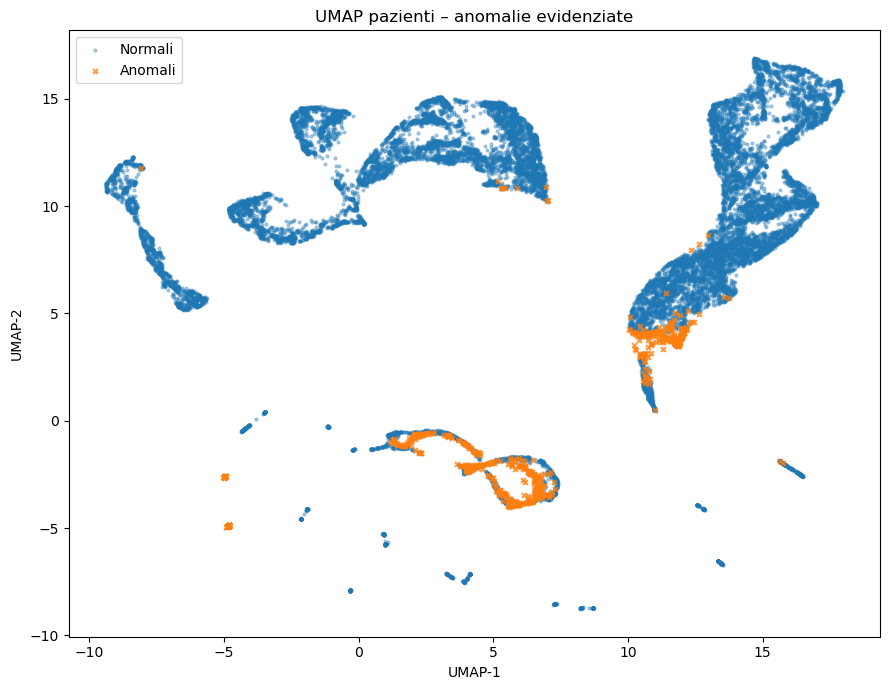

In [66]:
import numpy as np

pred = features["hdbscan_cluster"].values
max_points = 150000  # cambia se vuoi
if len(features) > max_points:
    idx = np.random.RandomState(42).choice(len(features), size=max_points, replace=False)
else:
    idx = np.arange(len(features))

X_scaled_plot = X_scaled[idx]
pred_plot = pred[idx]

# === 2) UMAP 2D
um = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
emb = um.fit_transform(X_scaled_plot)

# === 3) Scatter separando normali e anomali, puntini piccoli
is_outlier = (pred_plot == -1)
x1, x2 = emb[~is_outlier, 0], emb[~is_outlier, 1]
y1, y2 = emb[is_outlier, 0],  emb[is_outlier, 1]

plt.figure(figsize=(9,7))
# normali
plt.scatter(x1, x2, s=4, alpha=0.35, label="Normali")
# anomali
plt.scatter(y1, y2, s=12, alpha=0.8, label="Anomali", marker="x")

plt.title("UMAP pazienti – anomalie evidenziate")
plt.legend(loc="best")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()